# CaLM
## The Codon adaptation Language Model

Implementation of the [Codon adaptation Language Model (CaLM)](https://www.biorxiv.org/content/10.1101/2022.12.15.519894v1.abstract), a large protein language model has been trained on coding DNA, instead of amino acids. Embeddings from CaLM can be used to build automatic features for downstream machine learning tasks — like predicting a protein's function, the species it belongs to, or others. This Colab Notebook enables automatic embedding of an arbitrary number of proteins using the GPUs available at Google Colaboratory.  

CaLM is a research tool developed by Carlos Outeiral, at the Oxford Protein Informatics Group.

## Set up

In [1]:
! pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cpu
! pip3 install einops
! pip3 install rotary_embedding_torch
! pip3 install biopython
! python setup.py install

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu
running install
/opt/conda/lib/python3.9/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/setuptools/command/easy_install.py:144: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running bdist_egg
running egg_info
writing CaLM.egg-info/PKG-INFO
writing dependency_links to CaLM.egg-info/dependency_links.txt
writing requirements to CaLM.egg-info/requires.txt
writing top-level names to CaLM.egg-info/top_level.txt
reading manifest file 'CaLM.egg-info/SOURCES.txt'
writing manifest file 'CaLM.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
copying calm/pretrained.py -> build/lib/calm
creating bui

## Useful functions

In [102]:
import string


def _split_into_codons(seq):
    codons = [sequence[i:i+3] for i in range(0, len(sequence), 3)]
    return codons
        
def split_into_codons(seq):
  """Yield successive 3-letter chunks of a string/sequence."""
  return list(_split_into_codons(seq))

def randstr(N=20):
  """Returns a random alphanumerical string."""
  return ''.join(random.choice(string.ascii_uppercase + string.digits)
    for _ in range(N))
  
def is_dna(seq):
  """Checks if a sequence matches the DNA alphabet."""
  return set(seq.upper()).issubset({'A', 'T', 'C', 'G'})

def is_rna(seq):
  """Checks if a sequence matches the RNA alphabet."""
  return set(seq.upper()).issubset({'A', 'U', 'C', 'G'})

def check_valid_codons(seq):
  """Checks if a sequence has a number of symbols
  that is a multiple of three."""
  return len(seq) % 3 == 0

def check_start_codon(seq):
  """Checks that the start codon is correct."""
  if is_dna(seq):
    return seq[:3] == 'ATG'
  elif is_rna(seq):
    return seq[:3] == 'AUG'
  else:
    return False

def check_stop_codon(seq):
  """Checks that the stop codon is correct."""
  if is_dna(seq):
    return seq[-3:] in ['TGA', 'TAG', 'TAA']
  elif is_rna(seq):
    return seq[-3:] in ['UGA', 'UAG', 'UAA']
  else:
    return False

def check_no_interstitial_stop_codons(seq):
  codons = split_into_codons(seq)
  coding_positions = set(codons[:-1])
  if is_dna(seq):
    return {'TGA', 'TAG', 'TAA'} not in coding_positions
  elif is_rna(seq):
    return {'UGA', 'UAG', 'UAA'} not in coding_positions
  else:
    return False

## Embed a sequence

The following code exemplifies how to embed a sequence using CaLM. In order to embed a specific cDNA sequence, just modify the value of the `cDNA_sequence` variable.

In [3]:
cDNA_sequence = 'ATGGTATAGAGGCATTGA'
alphabet = 'DNA'

In [4]:
if cDNA_sequence == '':
  raise ValueError('No cDNA sequence was provided.')
if alphabet == 'DNA':
  if not is_dna(cDNA_sequence):
    raise ValueError('Provided DNA sequence did not pass sanity check.')
elif alphabet == 'RNA':
  if not is_rna(cDNA_sequence):
    raise ValueError('Provided RNA sequence did not pass sanity check.')
if not check_valid_codons(cDNA_sequence):
  raise ValueError('The number of nucleotides is not a multiple of three.')
if not check_start_codon(cDNA_sequence):
  raise ValueError('Invalid start codon.')
if not check_stop_codon(cDNA_sequence):
  raise ValueError('Invalid stop codon.')
if not check_no_interstitial_stop_codons(cDNA_sequence):
  raise ValueError('Provided sequence contains interstitial stop codons.')

In the paper we have used sequence representations, where the representations of all codons in a protein are averaged. This is the default output of CaLM:

In [2]:
from calm import CaLM

model = CaLM()

In [70]:
from calm.sequence import CodonSequence
import torch.nn.functional as F

class CaLMPluS(CaLM):

    def get_logits(self, sequence):
        
        if isinstance(sequence, str):
            seq = CodonSequence(sequence)
        elif isinstance(sequence, CodonSequence):
            seq = sequence
        else:
            raise ValueError('The input sequence must be a string or a CodonSequence instance.')

       
        tokens = self.tokenize(seq)
        output = self.model(tokens)
        logits = output['logits']
        logits = F.softmax(logits,dim=-1).detach().numpy()
        
        return logits

In [71]:
def read_fasta_nuc(file_path):
    nuc_data = []
    id = ""
    sequence = []

    with open(file_path, 'r') as fasta_file:
        
        for line in fasta_file:
            if line.startswith(">"):
                pass
                  #id = line[1:].split('|')[3]
            else:
                sequence = line
        nuc_data.append(sequence)
    return nuc_data

file_path = "./data/nuc.fasta"
nuc_data = read_fasta_nuc(file_path)
sequence = nuc_data[0]

In [132]:
codonsss = _split_into_codons(sequence)

It is also possible to obtain the raw, unaveraged embeddings:

In [164]:
calm_model = CaLMPluS()
# remove the start token and end token
logits = calm_model.get_logits(sequence)[:,1:-1,]
print("Logits shape:", logits.shape)

Logits shape: (1, 1274, 69)


In [82]:
tok_to_idx = calm_model.alphabet.tok_to_idx
codons = [i for i in tok_to_idx]

In [165]:
codon_to_amino_acid = {
    'AAA': 'K',   # Lysine
    'AAU': 'N',   # Asparagine
    'AAC': 'N',   # Asparagine
    'AAG': 'K',   # Lysine
    'AUA': 'I',   # Isoleucine
    'AUU': 'I',   # Isoleucine
    'AUC': 'I',   # Isoleucine
    'AUG': 'M',   # Methionine (Start codon)
    'ACA': 'T',   # Threonine
    'ACU': 'T',   # Threonine
    'ACC': 'T',   # Threonine
    'ACG': 'T',   # Threonine
    'AGA': 'R',   # Arginine
    'AGU': 'S',   # Serine
    'AGC': 'S',   # Serine
    'AGG': 'R',   # Arginine
    'UAA': '*',   # Stop codon
    'UAU': 'Y',   # Tyrosine
    'UAC': 'Y',   # Tyrosine
    'UAG': '*',   # Stop codon
    'UUA': 'L',   # Leucine
    'UUU': 'F',   # Phenylalanine
    'UUC': 'F',   # Phenylalanine
    'UUG': 'L',   # Leucine
    'UCA': 'S',   # Serine
    'UCU': 'S',   # Serine
    'UCC': 'S',   # Serine
    'UCG': 'S',   # Serine
    'UGA': '*',   # Stop codon
    'UGU': 'C',   # Cysteine
    'UGC': 'C',   # Cysteine
    'UGG': 'W',   # Tryptophan
    'CAA': 'Q',   # Glutamine
    'CAU': 'H',   # Histidine
    'CAC': 'H',   # Histidine
    'CAG': 'Q',   # Glutamine
    'CUA': 'L',   # Leucine
    'CUU': 'L',   # Leucine
    'CUC': 'L',   # Leucine
    'CUG': 'L',   # Leucine
    'CCA': 'P',   # Proline
    'CCU': 'P',   # Proline
    'CCC': 'P',   # Proline
    'CCG': 'P',   # Proline
    'CGA': 'R',   # Arginine
    'CGU': 'R',   # Arginine
    'CGC': 'R',   # Arginine
    'CGG': 'R',   # Arginine
    'GAA': 'E',   # Glutamic Acid
    'GAU': 'D',   # Aspartic Acid
    'GAC': 'D',   # Aspartic Acid
    'GAG': 'E',   # Glutamic Acid
    'GUA': 'V',   # Valine
    'GUU': 'V',   # Valine
    'GUC': 'V',   # Valine
    'GUG': 'V',   # Valine
    'GCA': 'A',   # Alanine
    'GCU': 'A',   # Alanine
    'GCC': 'A',   # Alanine
    'GCG': 'A',   # Alanine
    'GGA': 'G',   # Glycine
    'GGU': 'G',   # Glycine
    'GGC': 'G',   # Glycine
    'GGG': 'G'    # Glycine
}

In [166]:
import csv
csv_fname = "./data/CaLM_grammaticality.csv"

with open(csv_fname, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    header = codons
    csv_writer.writerow(header)
    for probs in logits:

        for row in probs:
            csv_writer.writerow(row)

In [167]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def plot_mut_site(df, site:str):
    data = df.iloc[site-1]
    plt.figure(figsize=(12, 6))
    sns.barplot(x=data.index, y=data.values)

    plt.title(f'Distribution of grammaticality in Site {site}', fontsize=16)
    plt.xlabel("Tokens", fontsize=12)
    plt.ylabel("Values", fontsize=12)

    plt.xticks(rotation=90)

    plt.tight_layout()
    plt.show()

In [168]:
amino_acid_to_codons = {
    'K': ['AAA', 'AAG'],                          # Lysine
    'N': ['AAU', 'AAC'],                          # Asparagine
    'I': ['AUA', 'AUU', 'AUC'],                   # Isoleucine
    'M': ['AUG'],                                 # Methionine
    'T': ['ACA', 'ACU', 'ACC', 'ACG'],            # Threonine
    'R': ['AGA', 'AGG', 'CGA', 'CGU', 'CGC', 'CGG'], #Arginine
    'S': ['AGU', 'AGC', 'UCA', 'UCU', 'UCC', 'UCG'], # Serine
    '*': ['UAA', 'UAG', 'UGA'],                   # Stop codons
    'Y': ['UAU', 'UAC'],                          # Tyrosine
    'L': ['UUA', 'UUG', 'CUA', 'CUU', 'CUC', 'CUG'], # Leucine
    'F': ['UUU', 'UUC'],                          # Phenylalanine
    'C': ['UGU', 'UGC'],                          # Cysteine
    'W': ['UGG'],                                 # Tryptophan
    'Q': ['CAA', 'CAG'],                          # Glutamine
    'H': ['CAU', 'CAC'],                          # Histidine
    'P': ['CCA', 'CCU', 'CCC', 'CCG'],            # Proline
    'E': ['GAA', 'GAG'],                          # Glutamic Acid
    'D': ['GAU', 'GAC'],                          # Aspartic Acid
    'V': ['GUA', 'GUU', 'GUC', 'GUG'],            # Valine
    'A': ['GCA', 'GCU', 'GCC', 'GCG'],            # Alanine
    'G': ['GGA', 'GGU', 'GGC', 'GGG']             # Glycine
}

In [173]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

grammaticality = pd.DataFrame(logits.reshape(1274, 69))
grammaticality.columns = codons


gem_to_prot = pd.DataFrame()
gem_to_prot['A'] = grammaticality[['GCA', 'GCU', 'GCC', 'GCG']].sum(axis=1).copy()
gem_to_prot['C'] = grammaticality[['UGU', 'UGC']].sum(axis=1).copy()
gem_to_prot['D'] = grammaticality[['GAU', 'GAC']].sum(axis=1).copy()
gem_to_prot['E'] = grammaticality[['GAA', 'GAG']].sum(axis=1).copy()
gem_to_prot['F'] = grammaticality[['UUU', 'UUC']].sum(axis=1).copy()
gem_to_prot['G'] = grammaticality[['GGA', 'GGU', 'GGC', 'GGG']].sum(axis=1).copy()
gem_to_prot['H'] = grammaticality[['CAU', 'CAC']].sum(axis=1).copy()
gem_to_prot['I'] = grammaticality[['AUA','AUU','AUC']].sum(axis=1).copy()
gem_to_prot['K'] = grammaticality[['AAA','AAG']].sum(axis=1).copy()
gem_to_prot['L'] = grammaticality[['UUA', 'UUG', 'CUA', 'CUU', 'CUC', 'CUG']].sum(axis=1).copy()
gem_to_prot['M'] = grammaticality[['AUG']].copy()
gem_to_prot['N'] = grammaticality[['AAU','AAC']].sum(axis=1).copy()
gem_to_prot['P'] = grammaticality[['CCA', 'CCU', 'CCC', 'CCG']].sum(axis=1).copy()
gem_to_prot['Q'] = grammaticality[['CAA', 'CAG']].sum(axis=1).copy()
gem_to_prot['R'] = grammaticality[['AGA', 'AGG', 'CGA', 'CGU', 'CGC', 'CGG']].sum(axis=1).copy()
gem_to_prot['S'] = grammaticality[['AGU', 'AGC', 'UCA', 'UCU', 'UCC', 'UCG']].sum(axis=1).copy()
gem_to_prot['T'] = grammaticality[['ACA','ACU','ACC','ACG']].sum(axis=1).copy()
gem_to_prot['V'] = grammaticality[['GUA', 'GUU', 'GUC', 'GUG']].sum(axis=1).copy()
gem_to_prot['W'] = grammaticality[['UGG']].sum(axis=1).copy()
gem_to_prot['Y'] = grammaticality[['UAU', 'UAC']].sum(axis=1).copy()
#gem_to_prot['*'] = grammaticality[['UAA', 'UAG', 'UGA']].sum(axis=1).copy()

In [174]:
gem_to_prot

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
0,0.000851,0.000507,0.000034,0.000039,0.003233,0.000372,0.000049,0.002856,0.000097,0.008776,0.978188,0.000205,0.000255,0.000169,0.000062,0.000857,0.000469,0.002298,0.000270,0.000412
1,0.005429,0.001516,0.000274,0.000307,0.925465,0.001790,0.000541,0.011144,0.000602,0.029050,0.001493,0.000866,0.000996,0.000662,0.000516,0.004035,0.002109,0.009503,0.001461,0.002238
2,0.013814,0.006560,0.000888,0.000857,0.022840,0.006944,0.001743,0.029158,0.000930,0.065016,0.002741,0.001792,0.005182,0.002041,0.000684,0.013075,0.006930,0.806639,0.004848,0.007308
3,0.010791,0.003528,0.000624,0.000566,0.874350,0.004757,0.000598,0.010796,0.000354,0.054359,0.001369,0.000827,0.003678,0.001419,0.000269,0.009872,0.003193,0.014978,0.001671,0.001999
4,0.022834,0.005024,0.000970,0.000828,0.012766,0.009422,0.000815,0.017217,0.000552,0.873158,0.003072,0.001728,0.002746,0.001922,0.000536,0.015244,0.007933,0.019138,0.001471,0.002617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1269,0.034357,0.006586,0.035467,0.055733,0.015864,0.047099,0.024395,0.033906,0.050640,0.353126,0.007945,0.030317,0.054353,0.032973,0.022518,0.056761,0.046197,0.055664,0.003889,0.032181
1270,0.030181,0.004978,0.036022,0.045946,0.015856,0.035897,0.448793,0.027902,0.049816,0.032938,0.006997,0.029959,0.034033,0.026719,0.016179,0.053173,0.039156,0.040535,0.003208,0.021683
1271,0.053768,0.004454,0.052277,0.081256,0.012384,0.043806,0.015202,0.021474,0.056556,0.031961,0.005423,0.027535,0.035381,0.032076,0.016476,0.059626,0.039407,0.050201,0.002506,0.358197
1272,0.007725,0.005515,0.010573,0.011052,0.015630,0.005765,0.015562,0.026409,0.046538,0.027485,0.007614,0.036270,0.014201,0.021314,0.013891,0.036344,0.663312,0.010533,0.003276,0.020975


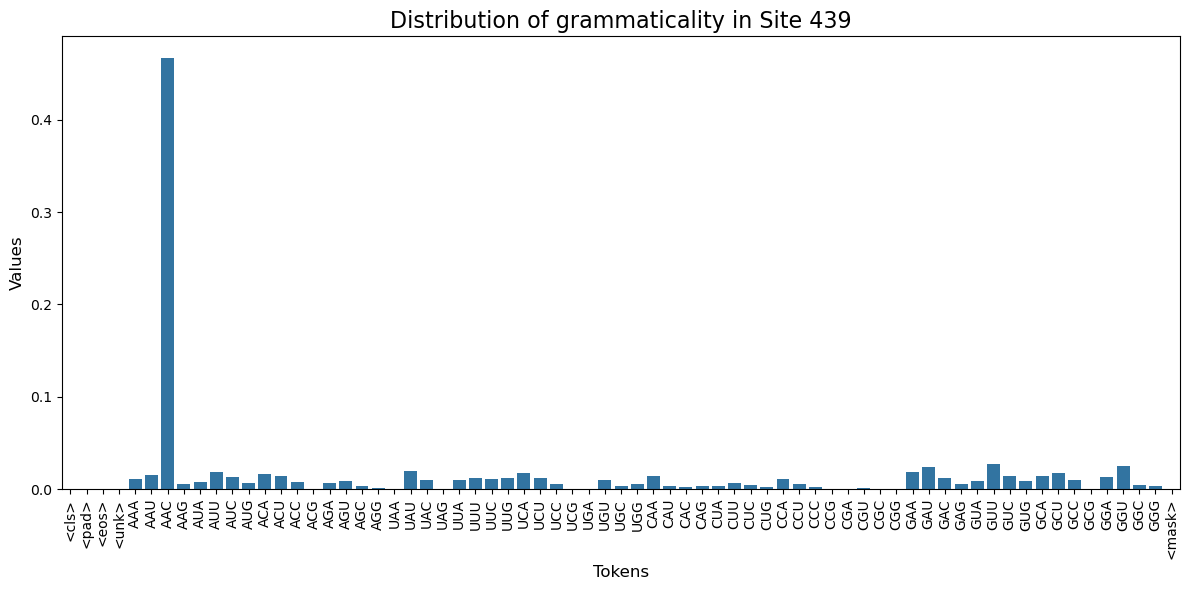

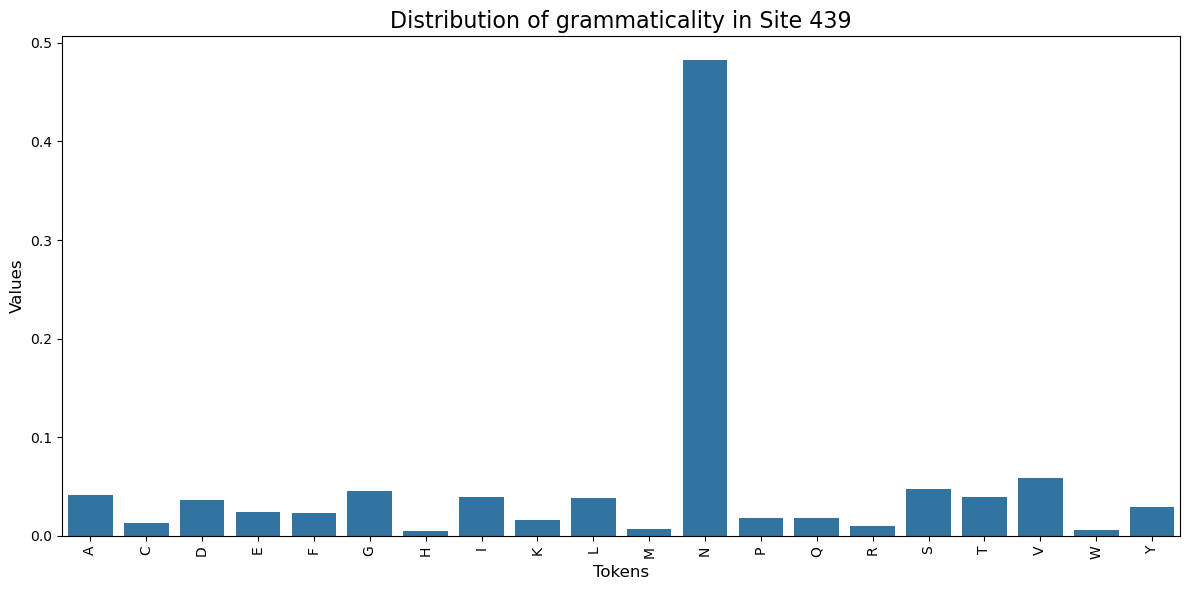

In [175]:
plot_mut_site(grammaticality,439)
plot_mut_site(gem_to_prot,439)

## ESM2

In [133]:
!pip install fair-esm
!pip install git+https://github.com/facebookresearch/esm.git

  Cloning https://github.com/facebookresearch/esm.git to /private/var/folders/3p/j_7p9xy94bg2v5n7fr5rq8d80000gn/T/pip-req-build-mbjrant8
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/esm.git /private/var/folders/3p/j_7p9xy94bg2v5n7fr5rq8d80000gn/T/pip-req-build-mbjrant8
  Resolved https://github.com/facebookresearch/esm.git to commit 2b369911bb5b4b0dda914521b9475cad1656b2ac
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for fair-esm: filename=fair_esm-2.0.1-py3-none-any.whl size=105379 sha256=4968d4426e9e2a09ce2fef38e9e2f37e650bc6b4dfb30e7eb1fcf862c08731b5
  Stored in directory: /private/var/folders/3p/j_7p9xy94bg2v5n7fr5rq8d80000gn/T/pip-ephem-wheel-cache-ozugcnhk/wheels/4d/93/84/94f97c0c2eb9e55cec3d98446534316a88262b407db4c247e7
Successfully built fair-esm
  Attempting uninstall: fair-esm
    Found existing installation: fair-esm 2.0.0
 

In [136]:
import torch
import esm

model, alphabet = torch.hub.load("facebookresearch/esm:main", "esm2_t33_650M_UR50D")
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()

Using cache found in /Users/cassie/.cache/torch/hub/facebookresearch_esm_main


ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
    (1): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bia

In [150]:
def read_fasta_prot(file_path):
    data = []
    protein_name = ""
    sequence = []

    with open(file_path, 'r') as fasta_file:

        for line in fasta_file:
            if line.startswith(">"):
                protein_name = line[1:-1]
                sequence = []
            else:
                sequence.append(line)

        data.append((protein_name, ''.join(sequence)))

    return data

# Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)
prot_path = "data/prot.fasta"
data = read_fasta_prot(prot_path)

In [151]:
batch_labels, batch_strs, batch_tokens = batch_converter(data)
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

# Extract per-residue representations (on CPU)
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[33], return_contacts=True)

logits = results["logits"]  # Get logits (unnormalized predictions)
# Apply softmax to get probabilities for each amino acid
probabilities = []
for pos, tokens_len in enumerate(batch_lens):
    logit = results["logits"]
      # remove start token
    grammaticality = F.softmax(logit[pos, 1 : tokens_len - 1], dim=-1).cpu().numpy()
    probabilities.append(grammaticality)

In [155]:
token_to_aa = {i: alphabet.get_tok(i) for i in range(len(alphabet))}
amino_acids = [token_to_aa[i] for i in range(len(alphabet))]
amino_acids

['<cls>',
 '<pad>',
 '<eos>',
 '<unk>',
 'L',
 'A',
 'G',
 'V',
 'S',
 'E',
 'R',
 'T',
 'I',
 'D',
 'P',
 'K',
 'Q',
 'N',
 'F',
 'Y',
 'M',
 'H',
 'W',
 'C',
 'X',
 'B',
 'U',
 'Z',
 'O',
 '.',
 '-',
 '<null_1>',
 '<mask>']

In [156]:
csv_fname = "./data/ESM2_grammaticality.csv"

with open(csv_fname, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    header = amino_acids
    csv_writer.writerow(header)
    for probs in probabilities:

        for row in probs:
            csv_writer.writerow(row)

In [161]:
ESM2_grammaticality = pd.read_csv("./data/ESM2_grammaticality.csv",sep=",")
# Selected common amino acids
ESM2_grammaticality = ESM2_grammaticality[
                ['A', 'C', 'D', 'E', 
                 'F', 'G', 'H', 'I', 
                 'K', 'L', 'M', 'N', 
                 'P', 'Q', 'R', 'S', 
                 'T', 'V', 'W', 'Y']
                ]

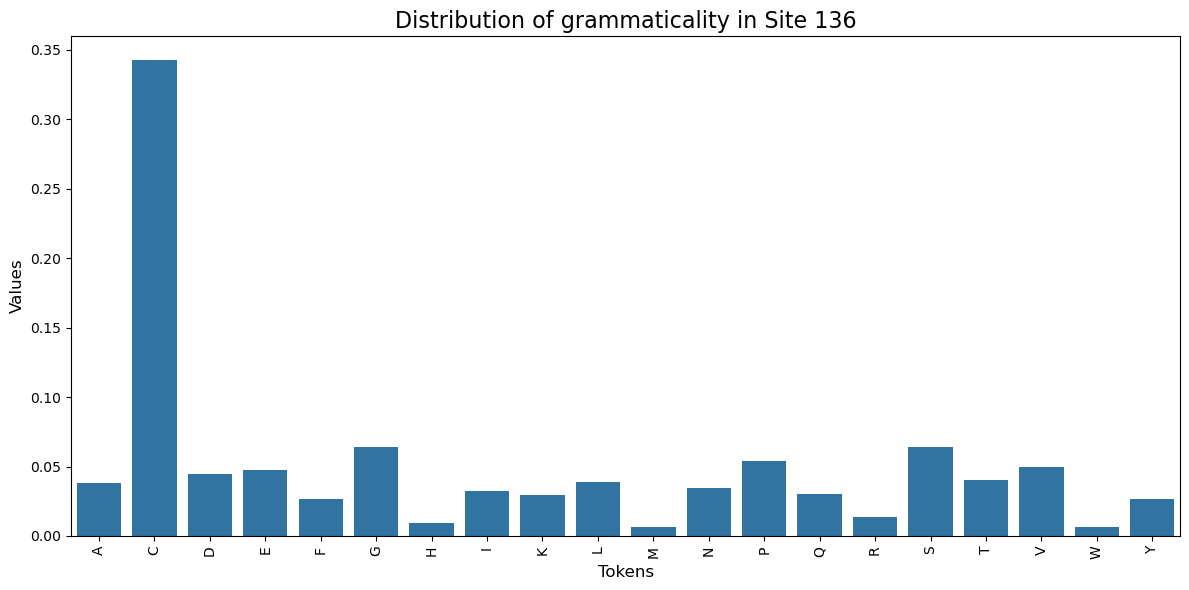

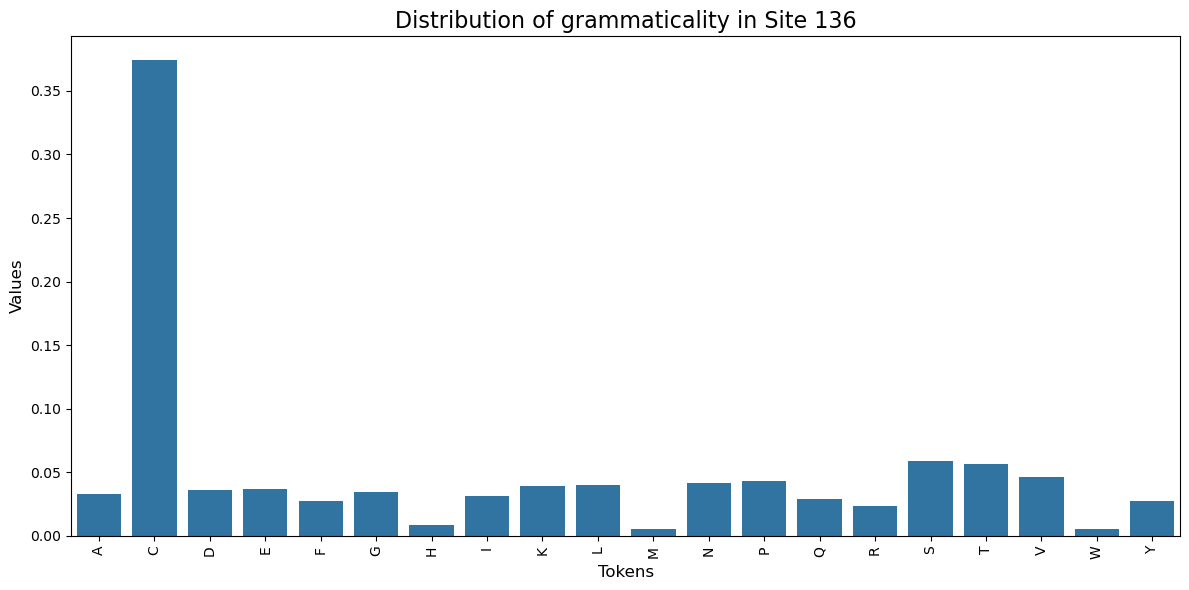

In [200]:
plot_mut_site(gem_to_prot,136)
plot_mut_site(ESM2_grammaticality,136)

## Correlation 

In [195]:
from scipy.stats import pearsonr


correlation, p_value = pearsonr(gem_to_prot.iloc[1237], ESM2_grammaticality.iloc[1237])

print("The Pearson correlation coefficient is：", correlation)
print("P value is：", p_value)

The Pearson correlation coefficient is： 0.8236860884580203
P value is： 8.088149194835537e-06
